In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torch.optim import AdamW
from transformers import RobertaModel
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForMaskedLM, pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA toolkit version:", torch.version.cuda)
print("Device name:", torch.cuda.get_device_name(0))

Torch version: 2.7.1+cu118
CUDA available: True
CUDA toolkit version: 11.8
Device name: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
pipe = pipeline("fill-mask", model="NLPC-UOM/SinBERT-large")

tokenizer = AutoTokenizer.from_pretrained("NLPC-UOM/SinBERT-large")
model = AutoModelForMaskedLM.from_pretrained("NLPC-UOM/SinBERT-large")

Device set to use cuda:0


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [4]:
df = pd.read_csv('./processed/processed_dataset.csv')

# After loading df and before defining criterion
labels = df['label'].values
class_sample_count = np.array([np.sum(labels == t) for t in np.unique(labels)])
weight = 1. / class_sample_count

#converts numpy array of weights to torch tensor and move it to the same device as the model
class_weights = torch.tensor(weight, dtype=torch.float).to(device)

# Use in loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer= AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

In [5]:
class_sample_count

array([502, 540, 504, 606, 507, 496])

## Creating the DataSet Class


the class wich represent the data.the dataloder will use this class to load the data one by one or in batches.it relies on 2 methods.

- `__len__`    - returns the length of the dataset
- `__getitem__` - returns the item at the given index
Also it has the constructor which takes the dataframe, tokenizer and max_length as input parameters.
- `__init__`- constructor to initialize the dataset with a dataframe, tokenizer, and maximum sequence length.
    - `self.text`,`self.label` - store the raw sinhala texts and labels from the dataframe.
    - `self.tokenizer` - stores the tokenizer object.
    - `self.max_length` - stores the maximum length of the input sequence.all the sentences will be padded or truncated to this length.

In [6]:
class SinhalaEmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        # Create label-to-index mapping
        self.label2idx = {label: idx for idx, label in enumerate(sorted(set(labels)))}
        self.labels = [self.label2idx[label] for label in labels]
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

## Dataloader

In [7]:
df_train,df_test=train_test_split(df,test_size=0.2,random_state=42,stratify=df['label'])#stratify is used to maintain the class distribution in the train and test sets(emotion percentages are same in both sets).

#Dataset and Dataloader
BATCH_SIZE = 16
# Instantiate the custom dataset for each split
train_dataset = SinhalaEmotionDataset(
    texts=df_train['text'].tolist(),
    labels=df_train['label'].tolist(),
    tokenizer=tokenizer
)

test_dataset = SinhalaEmotionDataset(
    texts=df_test['text'].tolist(),
    labels=df_test['label'].tolist(),
    tokenizer=tokenizer
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
# Set up the DataLoader for each split
train_data_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE
)

print("Data Loaders for training, validation, and testing are ready.")

Data Loaders for training, validation, and testing are ready.


## Building the Model Architecture


every pytorch model should inherit from `nn.Module` class. The model should have the following methods.
- `__init__` - constructor to initialize the model with a pre-trained BERT model and a CNN layer.
    - `self.bert` - stores the pre-trained BERT model.
    - `self.cnn` - stores the CNN layer.
    - `self.relu` - stores the ReLU activation function.
    - `self.pool` - stores the adaptive max pooling layer.

In [8]:
class SinbertCNN(nn.Module):
    """
    SinbertCNN combines a RoBERTa-based encoder with CNN layers for emotion classification.
    Args:
        num_labels (int): Number of output classes.
        embedding_dim (int): Dimensionality of SinBERT embeddings.
        num_filters (int): Number of filters per CNN layer.
        kernel_sizes (list): List of kernel sizes for CNN layers.
        dropout_rate (float): Dropout rate for regularization.
        pretrained_model_name (str): Name of the pretrained RoBERTa model.
    """
    def __init__(self, num_labels, embedding_dim=1024, num_filters=100, kernel_sizes=None, dropout_rate=0.5, pretrained_model_name="NLPC-UOM/SinBERT-large"):
        super(SinbertCNN, self).__init__()
        if kernel_sizes is None:
            kernel_sizes = [3, 4, 5]
        self.sinbert = RobertaModel.from_pretrained(pretrained_model_name)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim,
                      out_channels=num_filters,
                      kernel_size=k)
            for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.sinbert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state
        x = embeddings.permute(0, 2, 1)
        conv_outputs = [torch.relu(conv(x)) for conv in self.convs]
        pooled_outputs = [torch.max(conv_output, dim=2)[0] for conv_output in conv_outputs]
        concatenated_output = torch.cat(pooled_outputs, dim=1)
        dropout_output = self.dropout(concatenated_output)
        logits = self.fc(dropout_output)
        return logits

## Training the Model

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=3):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * input_ids.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).float().sum().item()
            total += labels.size(0)
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        # Validation
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * input_ids.size(0)
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).float().sum().item()
                val_total += labels.size(0)
        val_losses.append(val_running_loss / val_total)
        val_accuracies.append(val_correct / val_total)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")
    return train_losses, train_accuracies, val_losses, val_accuracies

def evaluate_metrics(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    return acc, precision, recall, f1

# Usage:
# Use your validation or test loader for proper evaluation
# acc, precision, recall, f1 = evaluate_metrics(model, val_loader, device)

In [10]:
!pip install ipywidgets


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Hyperparameter tuning

In [12]:
import torch

def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, device, epochs=10, patience=2):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * input_ids.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).float().sum().item()
            total += labels.size(0)
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * input_ids.size(0)
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).float().sum().item()
                val_total += labels.size(0)
        val_loss = val_running_loss / val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_state)
                break

    return train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
import itertools

# Define hyperparameter grid
param_grid = {
    'embedding_dim': [768, 1024],
    'num_filters': [50, 100],
    'kernel_sizes': [[3, 4, 5], [2, 3, 4, 5]],
    'dropout_rate': [0.3, 0.5],
}

all_combinations = list(itertools.product(
    param_grid['embedding_dim'],
    param_grid['num_filters'],
    param_grid['kernel_sizes'],
    param_grid['dropout_rate']
))

# Hyperparameter tuning loop with status bar
results = []
num_labels = len(df['label'].unique())

for emb_dim, num_filt, kernels, drop in tqdm(all_combinations, desc='Hyperparameter Tuning'):
    model = SinbertCNN(
        num_labels=num_labels,
        embedding_dim=emb_dim,
        num_filters=num_filt,
        kernel_sizes=kernels,
        dropout_rate=drop
    ).to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    train_model_with_early_stopping(
        model=model,
        train_loader=train_data_loader,
        val_loader=test_data_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        epochs=10,      # Set higher epochs
        patience=2      # Early stopping patience
    )
    acc, precision, recall, f1 = evaluate_metrics(model, test_data_loader, device)
    results.append({
        'params': (emb_dim, num_filt, kernels, drop),
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

# After hyperparameter tuning loop
best_result = max(results, key=lambda x: x['accuracy'])
print('Best hyperparameters:', best_result['params'])
print('Best accuracy:', best_result['accuracy'])
print('Best precision:', best_result['precision'])
print('Best recall:', best_result['recall'])
print('Best F1:', best_result['f1'])

# Plot performance metrics for all hyperparameter combinations
accuracies = [r['accuracy'] for r in results]
precisions = [r['precision'] for r in results]
recalls = [r['recall'] for r in results]
f1s = [r['f1'] for r in results]
labels = [str(r['params']) for r in results]

plt.figure(figsize=(12, 8))
plt.plot(labels, accuracies, marker='o', label='Accuracy')
plt.plot(labels, precisions, marker='o', label='Precision')
plt.plot(labels, recalls, marker='o', label='Recall')
plt.plot(labels, f1s, marker='o', label='F1 Score')
plt.xticks(rotation=90)
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Score')
plt.title('Performance Metrics Across Hyperparameter Combinations')
plt.legend()
plt.tight_layout()
plt.show()

Hyperparameter Tuning:   0%|          | 0/16 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at NLPC-UOM/SinBERT-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Validation

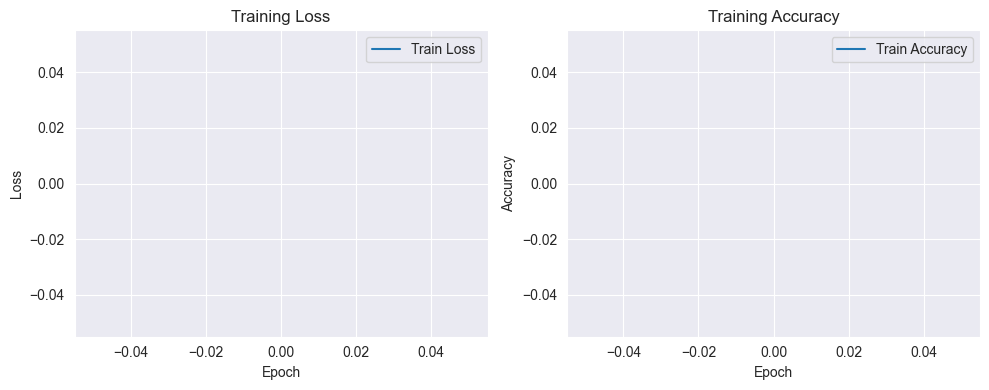

In [19]:
import matplotlib.pyplot as plt

# Example lists to store metrics
train_losses = []
train_accuracies = []

# After each epoch in your training loop, append metrics:
# train_losses.append(epoch_loss)
# train_accuracies.append(epoch_accuracy)

# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()